# Importing the necessary libraries & Loading the Dataset

In [1]:
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Download the dataset
paultimothymooney_chest_xray_pneumonia_path = kagglehub.dataset_download('paultimothymooney/chest-xray-pneumonia')

print(f"Downloaded dataset path: {paultimothymooney_chest_xray_pneumonia_path}")
# List contents of the downloaded dataset path
print("Dataset contents:")
for item in os.listdir(paultimothymooney_chest_xray_pneumonia_path):
    print(f"  {item}")

labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def get_training_data(data_dir):
    data = []
    print(f"Inspecting data_dir: {data_dir}") # Debug print
    for item in os.listdir(data_dir): #Inspect the content of data_dir
        print(f"  Found item: {item}")
    for label in labels:
        # Construct path assuming data_dir contains folders named 'NORMAL' and 'PNEUMONIA'
        path = os.path.join(data_dir, label)
        print(f"  Trying path: {path}")  # Debug print
        if not os.path.exists(path):
            print(f"    Path does not exist. Skipping {label}") # Debug Print
            continue
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                # Ensure all images are resized to the same shape before appending
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    # Convert the list of images to a NumPy array with a consistent shape
    # by specifying the dtype as object.
    return np.array(data, dtype=object)

# Construct the correct paths using paultimothymooney_chest_xray_pneumonia_path
# Assuming the structure is paultimothymooney_chest_xray_pneumonia_path/{train, test, val}/{NORMAL, PNEUMONIA}

train_path = os.path.join(paultimothymooney_chest_xray_pneumonia_path, 'chest_xray', 'train')
test_path = os.path.join(paultimothymooney_chest_xray_pneumonia_path, 'chest_xray', 'test')
val_path = os.path.join(paultimothymooney_chest_xray_pneumonia_path, 'chest_xray','val')


train = get_training_data(train_path)
test = get_training_data(test_path)
val = get_training_data(val_path)

100%|██████████| 2.29G/2.29G [00:14<00:00, 167MB/s]

Extracting files...


Downloaded dataset path: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2
Dataset contents:
  chest_xray
Inspecting data_dir: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train
  Found item: NORMAL
  Found item: PNEUMONIA
  Trying path: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/PNEUMONIA
  Trying path: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/NORMAL
Inspecting data_dir: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test
  Found item: NORMAL
  Found item: PNEUMONIA
  Trying path: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test/PNEUMONIA
  Trying path: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test/NORMAL
Inspecting data_dir: /root/.cache/kagglehub/d

# Data Visualization & Preprocessing

<Axes: xlabel='count'>

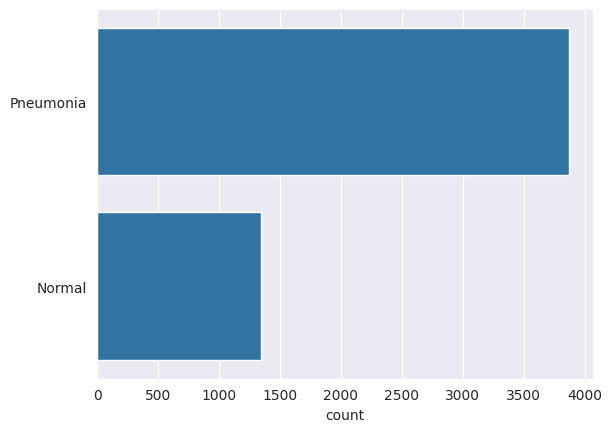

In [2]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)

**The data seems imbalanced . To increase the no. of training examples, we will use data augmentation**

**Previewing the images of both the classes**

Text(0.5, 1.0, 'NORMAL')

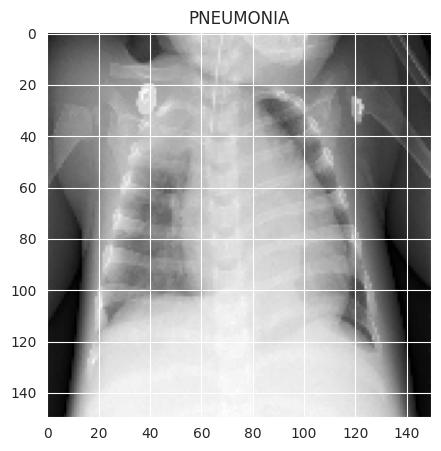

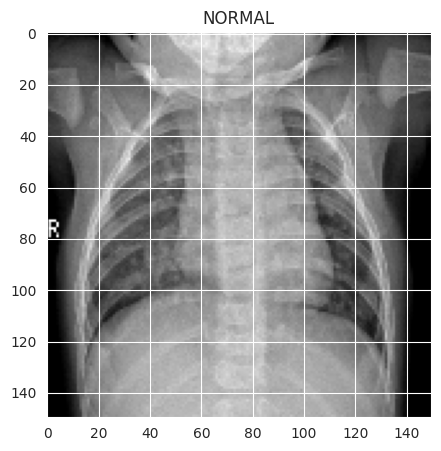

In [3]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [4]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

**We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].**

In [5]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [6]:
# resize data for deep learning
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

# Data Augmentation
**In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations.
Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.
By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.**

In [7]:
# import os
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Paths to save augmented images
# base_save_dir = '/content/augmented_images/'

# # Create directories for "Pneumonia" and "Normal" if they don't exist
# class_dirs = {'Pneumonia': os.path.join(base_save_dir, 'Pneumonia'), 'Normal': os.path.join(base_save_dir, 'Normal')}
# for class_name, class_path in class_dirs.items():
#     if not os.path.exists(class_path):
#         os.makedirs(class_path)

# With data augmentation to prevent overfitting and handling the imbalance in dataset

# datagen = ImageDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by std of the dataset
#         samplewise_std_normalization=False,  # divide each input by its std
#         zca_whitening=False,  # apply ZCA whitening
#         rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
#         zoom_range = 0.2, # Randomly zoom image
#         width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#         height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
#         horizontal_flip = True,  # randomly flip images
#         vertical_flip=False)  # randomly flip images

datagen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False  # Disable flipping
)


datagen.fit(x_train)

# # Save augmented images based on their class
# def save_augmented_images(x_data, y_data, class_dirs, num_augmented_images_per_class=100):
#     # Initialize counters for each class
#     pneumonia_count = 0
#     normal_count = 0

#     for i, (img, label) in enumerate(zip(x_data, y_data)):
#         label_name = 'Pneumonia' if label == 0 else 'Normal'
#         class_save_dir = class_dirs[label_name]

#         # Reshape image to be compatible with ImageDataGenerator
#         img = img.reshape((1,) + img.shape)

#         # Generate only if the class count hasn't reached the limit
#         if label_name == 'Pneumonia' and pneumonia_count < num_augmented_images_per_class:
#             for batch in datagen.flow(img, batch_size=1, save_to_dir=class_save_dir, save_prefix='aug', save_format='jpeg'):
#                 pneumonia_count += 1
#                 if pneumonia_count >= num_augmented_images_per_class:
#                     break
#         elif label_name == 'Normal' and normal_count < num_augmented_images_per_class:
#             for batch in datagen.flow(img, batch_size=1, save_to_dir=class_save_dir, save_prefix='aug', save_format='jpeg'):
#                 normal_count += 1
#                 if normal_count >= num_augmented_images_per_class:
#                     break

#     print(f"{pneumonia_count} Pneumonia images and {normal_count} Normal images saved.")

# # Save 100 augmented images per class
# save_augmented_images(x_train, y_train, class_dirs, num_augmented_images_per_class=100)

# import shutil
# from google.colab import files

# # Create a zip file of the augmented images directory
# shutil.make_archive('/content/augmented_images', 'zip', '/content/augmented_images')

# # Download the zip file
# files.download('/content/augmented_images.zip')


For the data augmentation, i chose to :
1. Randomly rotate some training images by 30 degrees
2. Randomly Zoom by 20% some training images
3. Randomly shift images horizontally by 10% of the width
4. Randomly shift images vertically by 10% of the height
5. Randomly flip images horizontally.
Once our model is ready, we fit the training dataset.

# Training the Model

In [8]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 38, 38, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 38, 38, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 38, 38, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 19, 19, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 19, 19, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 19, 19, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 19, 19, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 10, 10, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 10, 10, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6400)                │              

 Total params: 1,246,401 (4.75 MB)

 Trainable params: 1,245,313 (4.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [9]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [10]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 10 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 125s 744ms/step - accuracy: 0.8094 - loss: 1.0007 - val_accuracy: 0.5000 - val_loss: 24.0318 - learning_rate: 0.0010
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 123s 753ms/step - accuracy: 0.8997 - loss: 0.2741 - val_accuracy: 0.5000 - val_loss: 21.4355 - learning_rate: 0.0010
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 750ms/step - accuracy: 0.9148 - loss: 0.2092
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 ━━━━━━━━━━━━━━━━━━━━ 123s 751ms/step - accuracy: 0.9148 - loss: 0.2093 - val_accuracy: 0.5000 - val_loss: 25.0484 - learning_rate: 0.0010
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 123s 750ms/step - accuracy: 0.9369 - loss: 0.1661 - val_accuracy: 0.5000 - val_loss: 20.8169 - learning_rate: 3.0000e-04
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 125s 763ms/step - accuracy: 0.9554 - loss: 0.1282 - val_accuracy: 0.6875 - val_loss: 0.7480 - learning_rate: 3.0000e-04
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 126s 770ms/step - accuracy

In [11]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.9515 - loss: 0.1922
Loss of the model is -  0.21916846930980682
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9515 - loss: 0.1922
Accuracy of the model is -  92.78846383094788 %


**Save & Download the Model**

In [12]:
model.save('pneumonia_detection_model.h5')
from google.colab import files
files.download('pneumonia_detection_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Analysis after Model Training

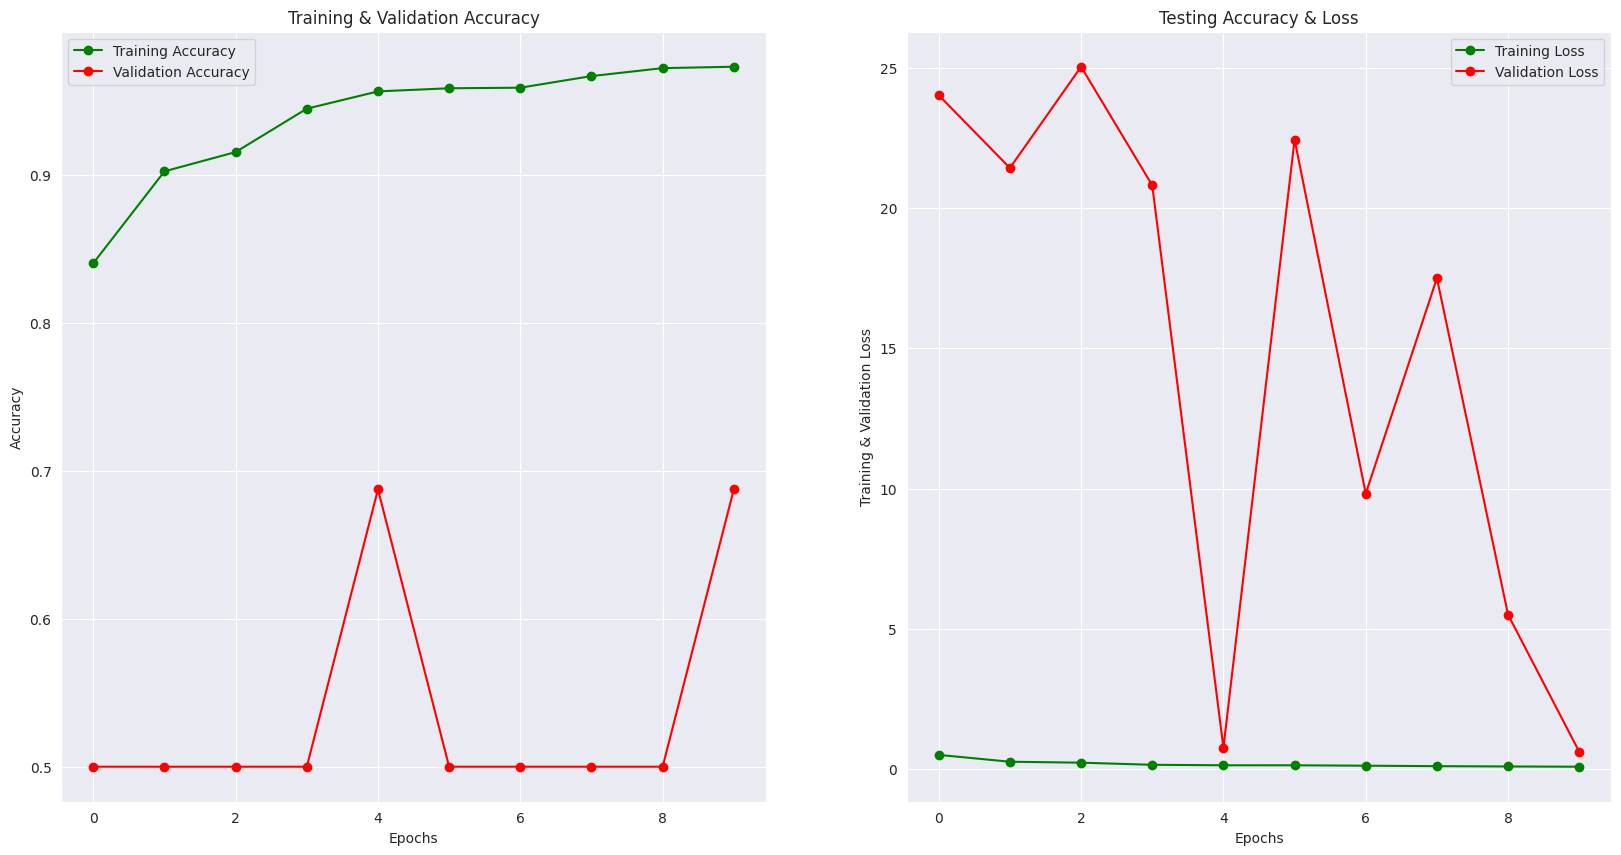

In [13]:
epochs = [i for i in range(len(history.history['accuracy']))] # Change epochs to match the length of training metrics
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [14]:
predictions = (model.predict(x_test) > 0.5).astype("int32") # Use predict and convert to classes
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [15]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.93      0.96      0.94       390
   Normal (Class 1)       0.92      0.88      0.90       234

           accuracy                           0.93       624
          macro avg       0.93      0.92      0.92       624
       weighted avg       0.93      0.93      0.93       624



In [16]:
cm = confusion_matrix(y_test,predictions)
cm

array([[373,  17],
       [ 28, 206]])

In [17]:
import pandas as pd
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<Axes: >

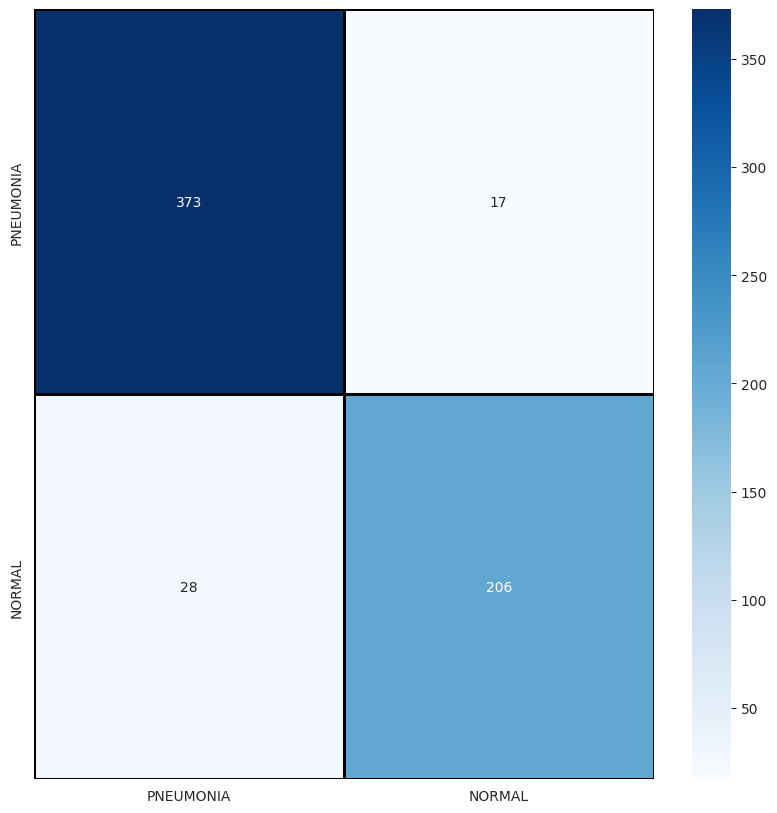

In [18]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [19]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

**Some of the Correctly Predicted Classes**

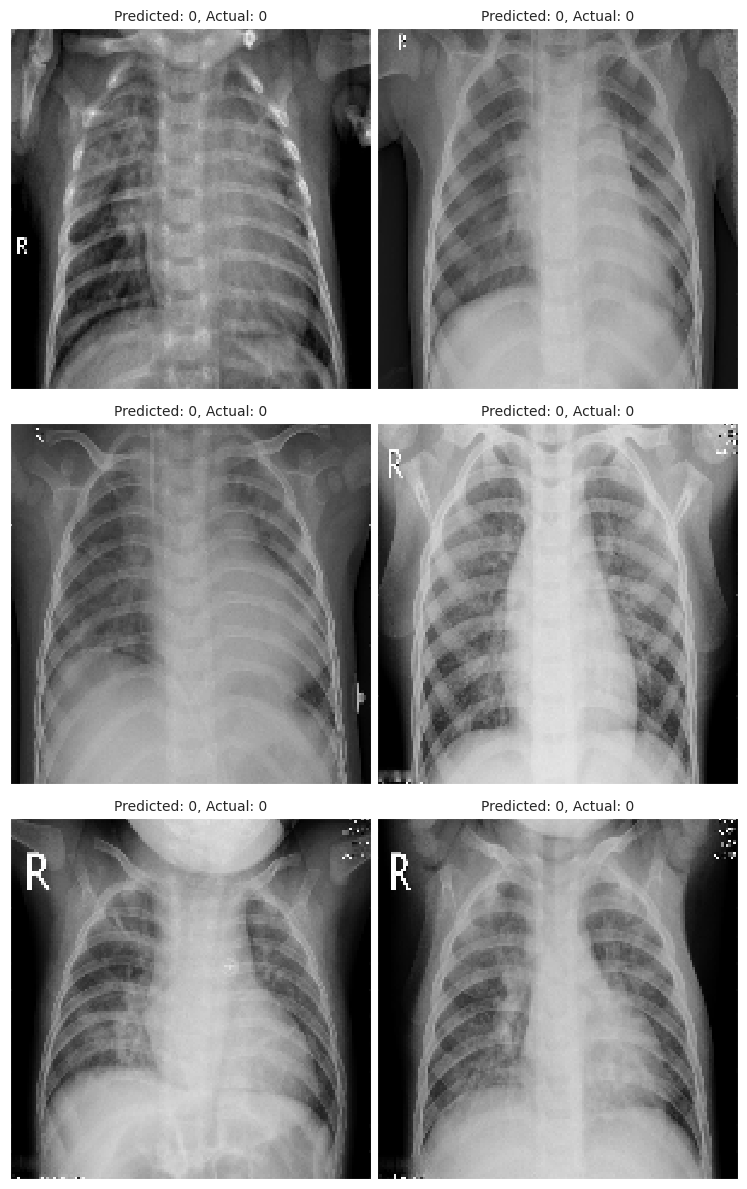

In [20]:
i = 0
plt.figure(figsize=(8, 12))  # Increase figure size for better spacing

for c in correct[:6]:
    plt.subplot(3, 2, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150, 150), cmap="gray", interpolation='none')
    plt.title(f"Predicted: {predictions[c]}, Actual: {y_test[c]}", fontsize=10)
    i += 1

plt.subplots_adjust(hspace=0.5)  # Add vertical spacing between plots
plt.tight_layout()
plt.show()

**Some of the Incorrectly Predicted Classes**

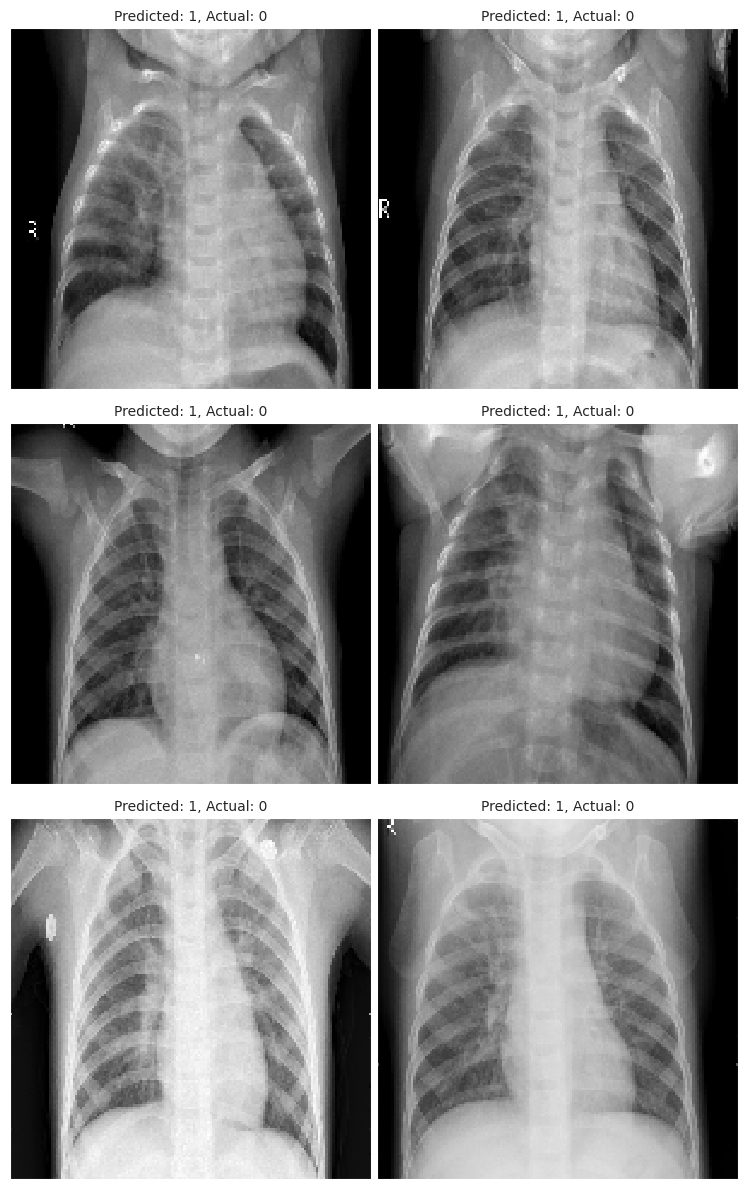

In [21]:
i = 0
plt.figure(figsize=(8, 12))  # Increase figure size for better spacing

for c in incorrect[:6]:
    plt.subplot(3, 2, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150, 150), cmap="gray", interpolation='none')
    plt.title(f"Predicted: {predictions[c]}, Actual: {y_test[c]}", fontsize=10)
    i += 1

plt.subplots_adjust(hspace=0.5)  # Add vertical spacing between plots
plt.tight_layout()
plt.show()